# Analyzing Evictions in the City of San Francisco 

## Stat 159, Spring 2023 

Group members: Yiran Li, Carrie Hu, Angelo Punzalan, Oona Risse-Adams

In this notebook, we will take in the Eviction_Notices.csv file from [data.gov](https://catalog.data.gov/dataset/eviction-notices) and analyze any possible patterns of evictions in San Francisco. 

## Project Motivation 

San Francisco is known as one of the more expensive cities to live in the United States, ranking number 20 in the [2022-2023 U.S. News Rankings](https://realestate.usnews.com/places/rankings/most-expensive-places-to-live). Within San Francisco, there are a myriad of different neighborhoods, each with their own unique aesthetic. However, the good sides always come with the bad. Seeing as how rent prices keep getting higher and more difficult to afford within the Bay Area, we decided to analyze some data and see if there were any particular reasons tenants got evicted other than inability to pay rent.

## Loading in the Data 

For the first step of our data, we have to load it in. We import the necessary packages and use pandas to use the pd.read_csv() function in order to load the dataframe in:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium
import re
import json
from tools import utils as ul

## Data Cleaning

The first step that we took to cleaning San Francisco eviction data was to select the relevant columns, including the address and file dates. The columns dropped are ones including access to police and other services. The question at hand is to interrogate the relationship between location and eviction cause, so access to public goods and services is not relevant to this stage of the analysis. Then, we dropped the rows which were missing values, for the ease of analysis. Finally, we randomly sampled the complete data to mitigate the impacts of an underlying correlation between the completeness of the eviction order and the location of the residence. 

In [2]:
evictions = pd.read_csv('data/Eviction_Notices.csv', engine='python', on_bad_lines='skip')
bad_reasons = evictions[['Eviction ID', 'Address', 'Eviction Notice Source Zipcode', 'File Date', 'Non Payment', 
                         'Nuisance', 'Illegal Use', 'Unapproved Subtenant', 'Demolition', 'Ellis Act WithDrawal', 
                         'Late Payments', 'Failure to Sign Renewal', 'Neighborhoods - Analysis Boundaries']].dropna()

sample = bad_reasons.sample(5000).rename({'Neighborhoods - Analysis Boundaries': 'Neighborhoods', 'Eviction Notice Source Zipcode': 'Zip'}, axis=1)

sample['Zip'] = sample['Zip'].astype(np.int64)
sample['File Date'] = pd.to_datetime(sample['File Date'])
sample['year'] = pd.DatetimeIndex(sample['File Date']).year
sample['month'] = pd.DatetimeIndex(sample['File Date']).month

sample.head()

,Eviction ID,Address,Zip,File Date,Non Payment,Nuisance,Illegal Use,Unapproved Subtenant,Demolition,Ellis Act WithDrawal,Late Payments,Failure to Sign Renewal,Neighborhoods,year,month
67404,M070700,900 Block Of Randolph Street,94132,2007-05-03,False,False,False,False,False,False,False,False,Oceanview/Merced/Ingleside,2007,5
91499,M161691,800 Block Of Shotwell Street,94110,2016-05-19,False,False,False,False,False,False,False,False,Mission,2016,5
2853,M193101,900 Block Of Capp Street,94110,2019-11-22,False,False,False,False,False,False,False,False,Mission,2019,11
13409,M181081,300 Block Of Haight Street,94117,2018-04-05,False,False,False,False,False,False,False,False,Hayes Valley,2018,4
28569,M071344,6200 Block Of 03rd Street,94124,2007-08-23,False,False,False,False,False,False,True,False,Bayview Hunters Point,2007,8


## Basic Visualization

To visualize the data, we decided to create bar graphs to generate an idea of the number of eviction notices in each Neighborhood, Year, and Month. 

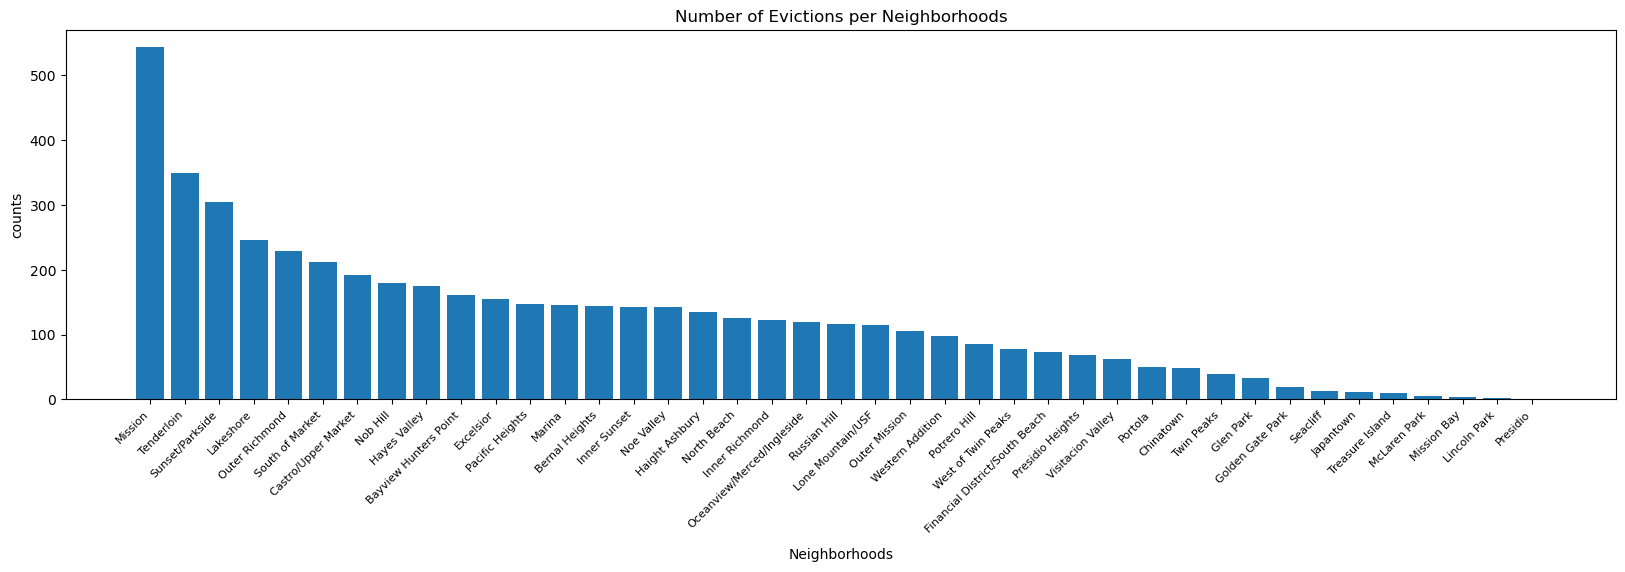

In [3]:
ul.get_count_plot(sample, 'Neighborhoods')
plt.savefig("figs/NumberOfEvictionsPerNeighborhood.png")

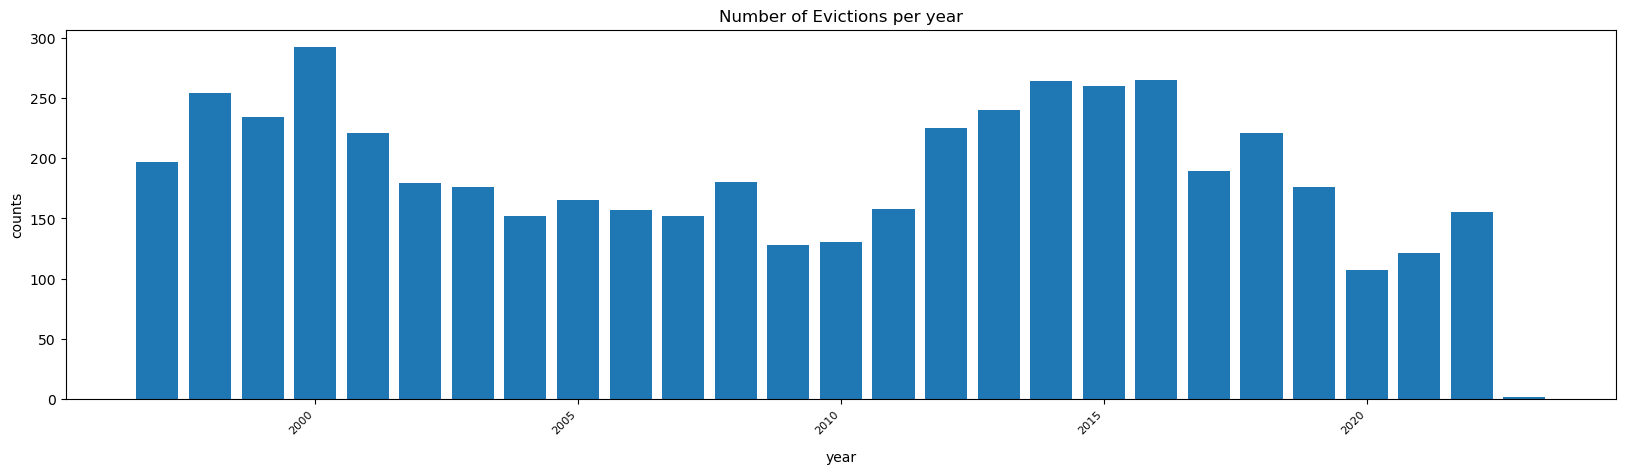

In [4]:
ul.get_count_plot(sample, 'year')
plt.savefig("figs/NumberOfEvictionsPerYear.png")

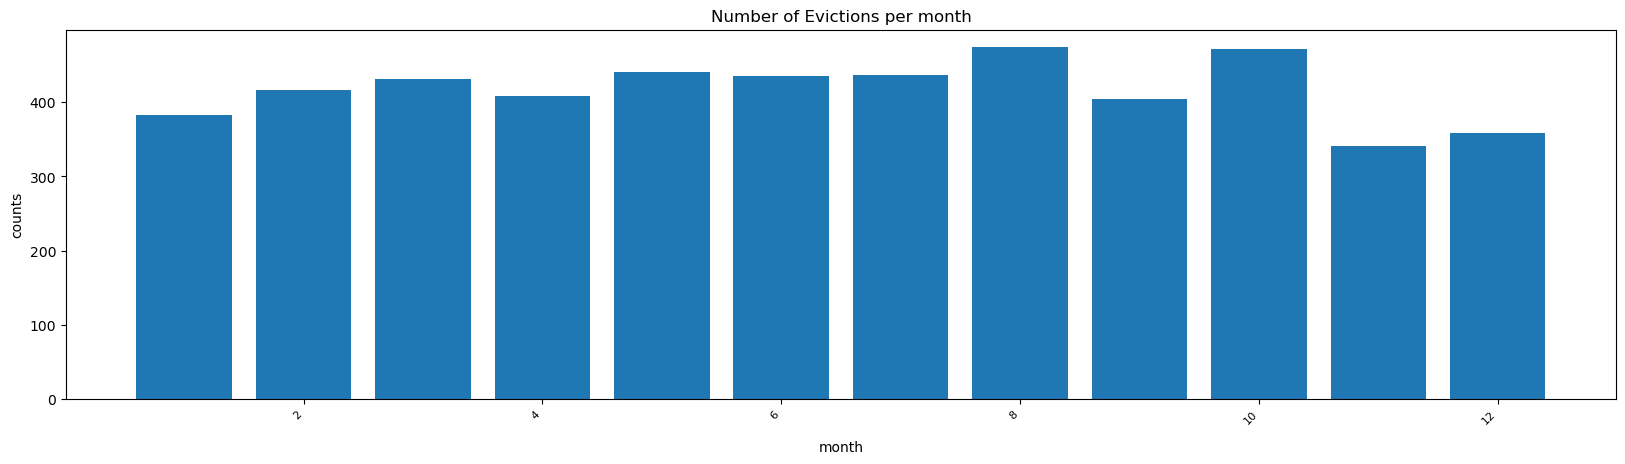

In [5]:
ul.get_count_plot(sample, 'month')
plt.savefig("figs/NumberOfEvictionsPerMonth.png")

The most common reason for evictions in San Francisco from 1997 - 2022 is Nuisance, followed by an Ellis Act Withdrawl. The high number of Ellis Act Withdrawl evictions is of note.

In [6]:
counts_df = sample[['Zip']].value_counts().reset_index(name='counts')
counts_df_clean = counts_df[counts_df['Zip'] > 90000]

In [7]:
with open('data/SanFrancisco.Neighborhoods.json', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# remove ZIP codes not in our dataset
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['id'] in list(counts_df_clean['Zip'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("data/updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

159085

In [8]:
ul.create_map(counts_df_clean, zips = 'Zip', feature = 'counts')

AttributeError: module 'tools.utils' has no attribute 'create_map'

In [ ]:
import pdfkit
pdfkit.from_file('figs/counts_map.html', 'map.pdf')

In [ ]:
from IPython.display import IFrame
IFrame("./samples/simple3.pdf", width=600, height=300)

Through this basic visualization, we see that the Mission is the Neighborhood with the highest number of evictions. From 1997 - 2023, the highest number of evictions in San Francisco was during 2000. The month with the highest number of evictions is August. 

## Calculating the Number of Evictions Per Reason

The following cell calculates the number of evictions per eviction reason. 

In [ ]:
#Finding the Exact Number of Evictions per Reason
reasons = sample.iloc[:, 3:11]
for col in reasons.columns:
    print(sample[[col]].value_counts().reset_index(name='counts'))

In [ ]:
def reason_for_evict(df, names):
    """
    This function aims to get the total number of the reasons for eviction for each different reason,
    and display the result in the form of a barplot.
    The arugument 'names' is a list of the names for certain eviction reasons that you want to look into.
    """
    
    #self.names = names
    reasons = df[names]
    
    columnNames = reasons.columns
    
    # create an empty dictionary for the reasons that has TRUE input for future counts
    trues_oc = {}

    # get the total number of TRUE observations for each reason of eviction and print it 
    for i in reasons.columns:
        trues_oc[i] = reasons[i].sum()
    print(trues_oc)

    # make it into a dataframe for plotting purpose
    argh = pd.DataFrame(trues_oc, ['True'], columnNames).reset_index()
    #print(argh)

    # print the result
    reasons_list = [column for column in argh.columns]
    #print(reasons_list)
    reasons_bar = argh.plot(figsize=(8,5), x='index', y=reasons_list[1:], kind='bar', rot=0)
    plt.xlabel('Reasons', labelpad = 10)
    plt.ylabel('counts')
    plt.title("Reasons count for Different Reasons for Eviction")
    plt.legend(loc='best', fontsize='7')


names = ['Non Payment', 'Nuisance', 'Illegal Use', 
                     'Unapproved Subtenant', 'Demolition', 'Ellis Act WithDrawal', 'Late Payments', 
                     'Failure to Sign Renewal']

reason_for_evict(sample, names)

The most common reason for evictions in San Francisco from 1997 - 2022 is Nuisance, followed by an Ellis Act Withdrawl. The high number of Ellis Act Withdrawl evictions is of note.   